In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import sys
sys.path.append("../")
from models.topics import TopicExtractionModel
from sentence_transformers import SentenceTransformer

In [3]:
headlines = pd.read_json("../data/raw/headlines.json", lines=True)
headline_embeddings = pd.read_parquet("../data/headline_embeddings.parquet")
headlines_merged = pd.merge(headlines, headline_embeddings, on="id", how="left")

In [42]:
from models.topics import NonStationaryFilter, HighKurtosisFilter, CompoundFilter
YEAR = 1983
sample_year = headlines_merged[headlines_merged["year"] == YEAR]

model = SentenceTransformer("all-MiniLM-L6-v2")
ns_filter = NonStationaryFilter(pvalue_threshold=0.1, n_periods=3)
kt_filter = HighKurtosisFilter(kurtosis_threshold=2)
compound_filter = CompoundFilter([ns_filter, kt_filter])
tm = TopicExtractionModel(model, topic_filter=compound_filter)
tm.fit(sample_year["headline"].tolist(), np.stack(sample_year["embedding"].tolist()), sample_year["month"].tolist())


In [34]:
tm.model.visualize_topics_over_time(tm.topics_over_time[tm.topics_over_time.Topic.isin(tm.topic_filter.topics)])

In [35]:
tm.compute_alignment(tm.centroids)

array([7.676026 , 7.729986 , 7.958832 , 8.940803 , 5.3474736, 8.047256 ,
       7.9106092, 8.103104 , 6.7226806, 5.4936266, 5.48057  , 8.166957 ,
       7.11946  , 5.4218726, 7.263571 , 8.491496 , 5.0566196, 7.492132 ,
       7.060274 , 4.82623  , 4.3095446, 2.7194328, 6.9534283, 6.189779 ,
       7.6879416], dtype=float32)

In [36]:
novels = pd.read_csv("../data/nominated_novels.csv")
description_embeddings = pd.read_parquet("../data/description_embeddings.parquet")
desc_merged = pd.get_dummies(novels[novels.year == YEAR], columns=['gender']).merge(description_embeddings, on="work_qid", how="left").groupby("work_qid").agg({
    'age': 'mean',
    'awards_as_of_year': 'sum',
    'embedding': 'first',
    'n_win': 'first',
    'n_nom': 'first',
    'gender_male': 'sum',
    'gender_female': 'sum',
}).dropna()

desc_merged.count()

age                  28
awards_as_of_year    28
embedding            28
n_win                28
n_nom                28
gender_male          28
gender_female        28
dtype: int64

In [37]:
from models.debias import NullspaceProjector, learn_nullspace_normal_vector

train_desc = pd.read_csv("../data/train_desc_labeled.csv")
w = learn_nullspace_normal_vector(train_desc)
db = NullspaceProjector(normal_vector=w)
embeddings = db.transform(np.stack(desc_merged["embedding"].values))
db.fit(embeddings)
desc_aligned = desc_merged.assign(
    cosine=tm.compute_alignment(embeddings, metric="cosine"),
    linear=tm.compute_alignment(embeddings, metric="linear"),
    rbf=tm.compute_alignment(embeddings, metric="rbf", gamma=5),
).melt(
    value_vars=["cosine", "linear", "rbf"],
    value_name="alignment",
    var_name="metric",
    ignore_index=False,
).join(desc_merged, how="left").assign(won=lambda x: x.n_win > 0)
desc_aligned.head()

,metric,alignment,age,awards_as_of_year,embedding,n_win,n_nom,gender_male,gender_female,won
work_qid,,,,,,,,,,
Q1138582,cosine,-0.456597,55.0,16,"[-0.0552539, -0.017166685, -0.023110507, 0.039...",0,1,1,0,False
Q128324,cosine,0.527409,31.0,1,"[-0.07045932, -0.029929008, -0.039669994, -0.0...",1,0,1,0,True
Q131375459,cosine,-0.534038,52.0,2,"[0.014932743, 0.008455961, 0.036621794, 0.0107...",0,1,0,1,False
Q131375476,cosine,1.018936,31.0,2,"[-0.11120238, -0.06832786, -0.023779087, -0.01...",0,1,1,0,False
Q15034210,cosine,0.523245,46.0,0,"[-0.06510513, 0.012740441, -0.010297849, -0.11...",0,1,1,0,False


<Axes: xlabel='alignment', ylabel='Density'>

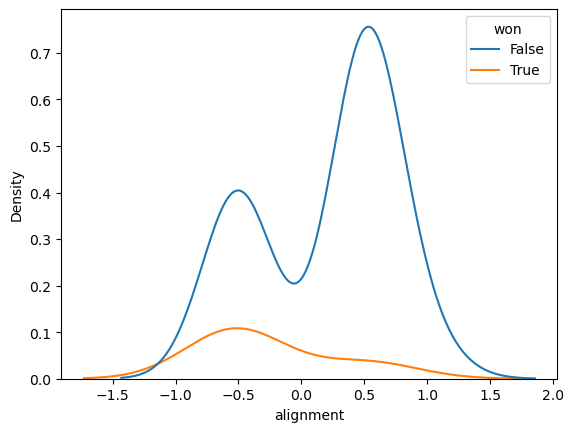

In [38]:
sns.kdeplot(x="alignment", data=desc_aligned[desc_aligned.metric == "cosine"], hue='won', common_norm=True )

<Axes: xlabel='alignment', ylabel='Density'>

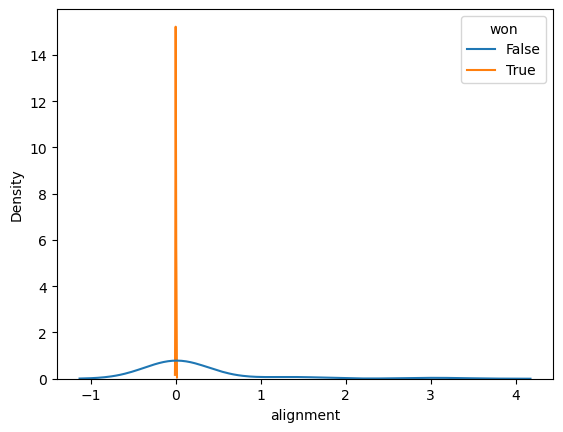

In [39]:
sns.kdeplot(x="alignment", data=desc_aligned[desc_aligned.metric == "rbf"], hue='won', common_norm=True )

<Axes: xlabel='alignment', ylabel='Density'>

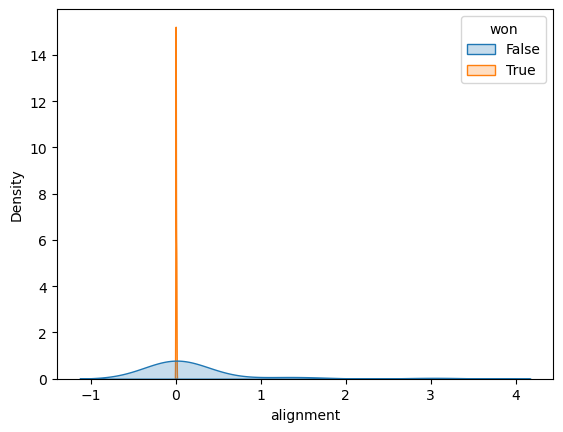

In [40]:
sns.kdeplot(x="alignment", data=desc_aligned[desc_aligned.metric == "rbf"], hue='won', common_norm=True , fill=True)

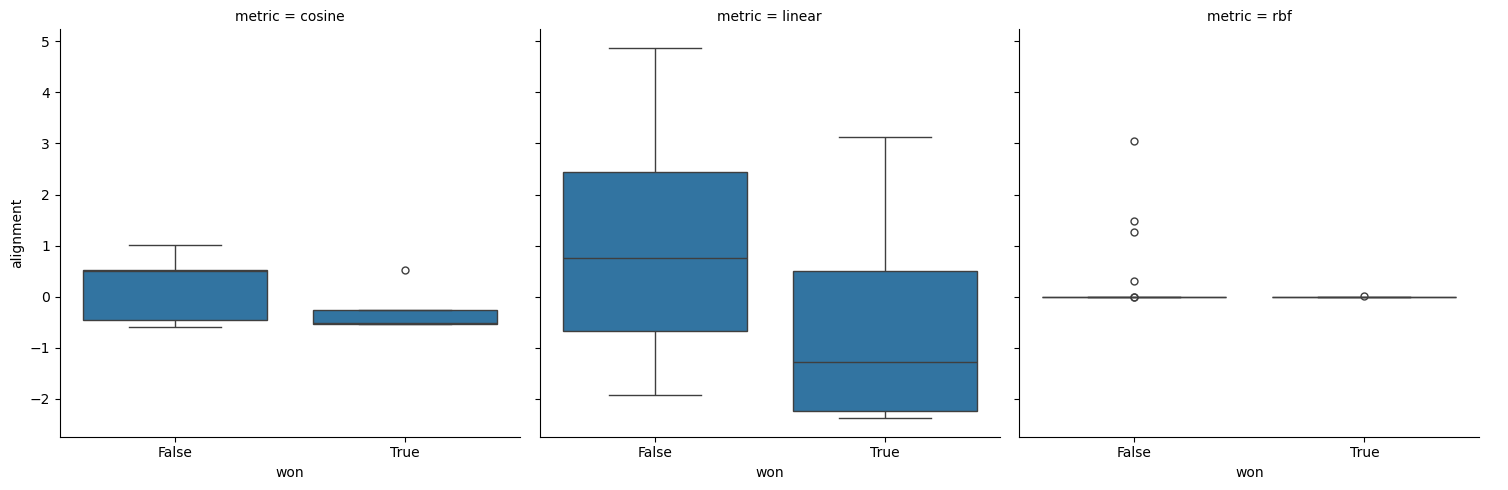

In [41]:
sns.catplot(x="won", y="alignment", data=desc_aligned, kind="box", col="metric")

In [28]:
from sklearn.feature_selection import mutual_info_regression
mutual_info_regression(desc_aligned[["alignment", "age", "awards_as_of_year"]], desc_aligned["n_win"])

array([0.01513142, 0.03433112, 0.02576734])

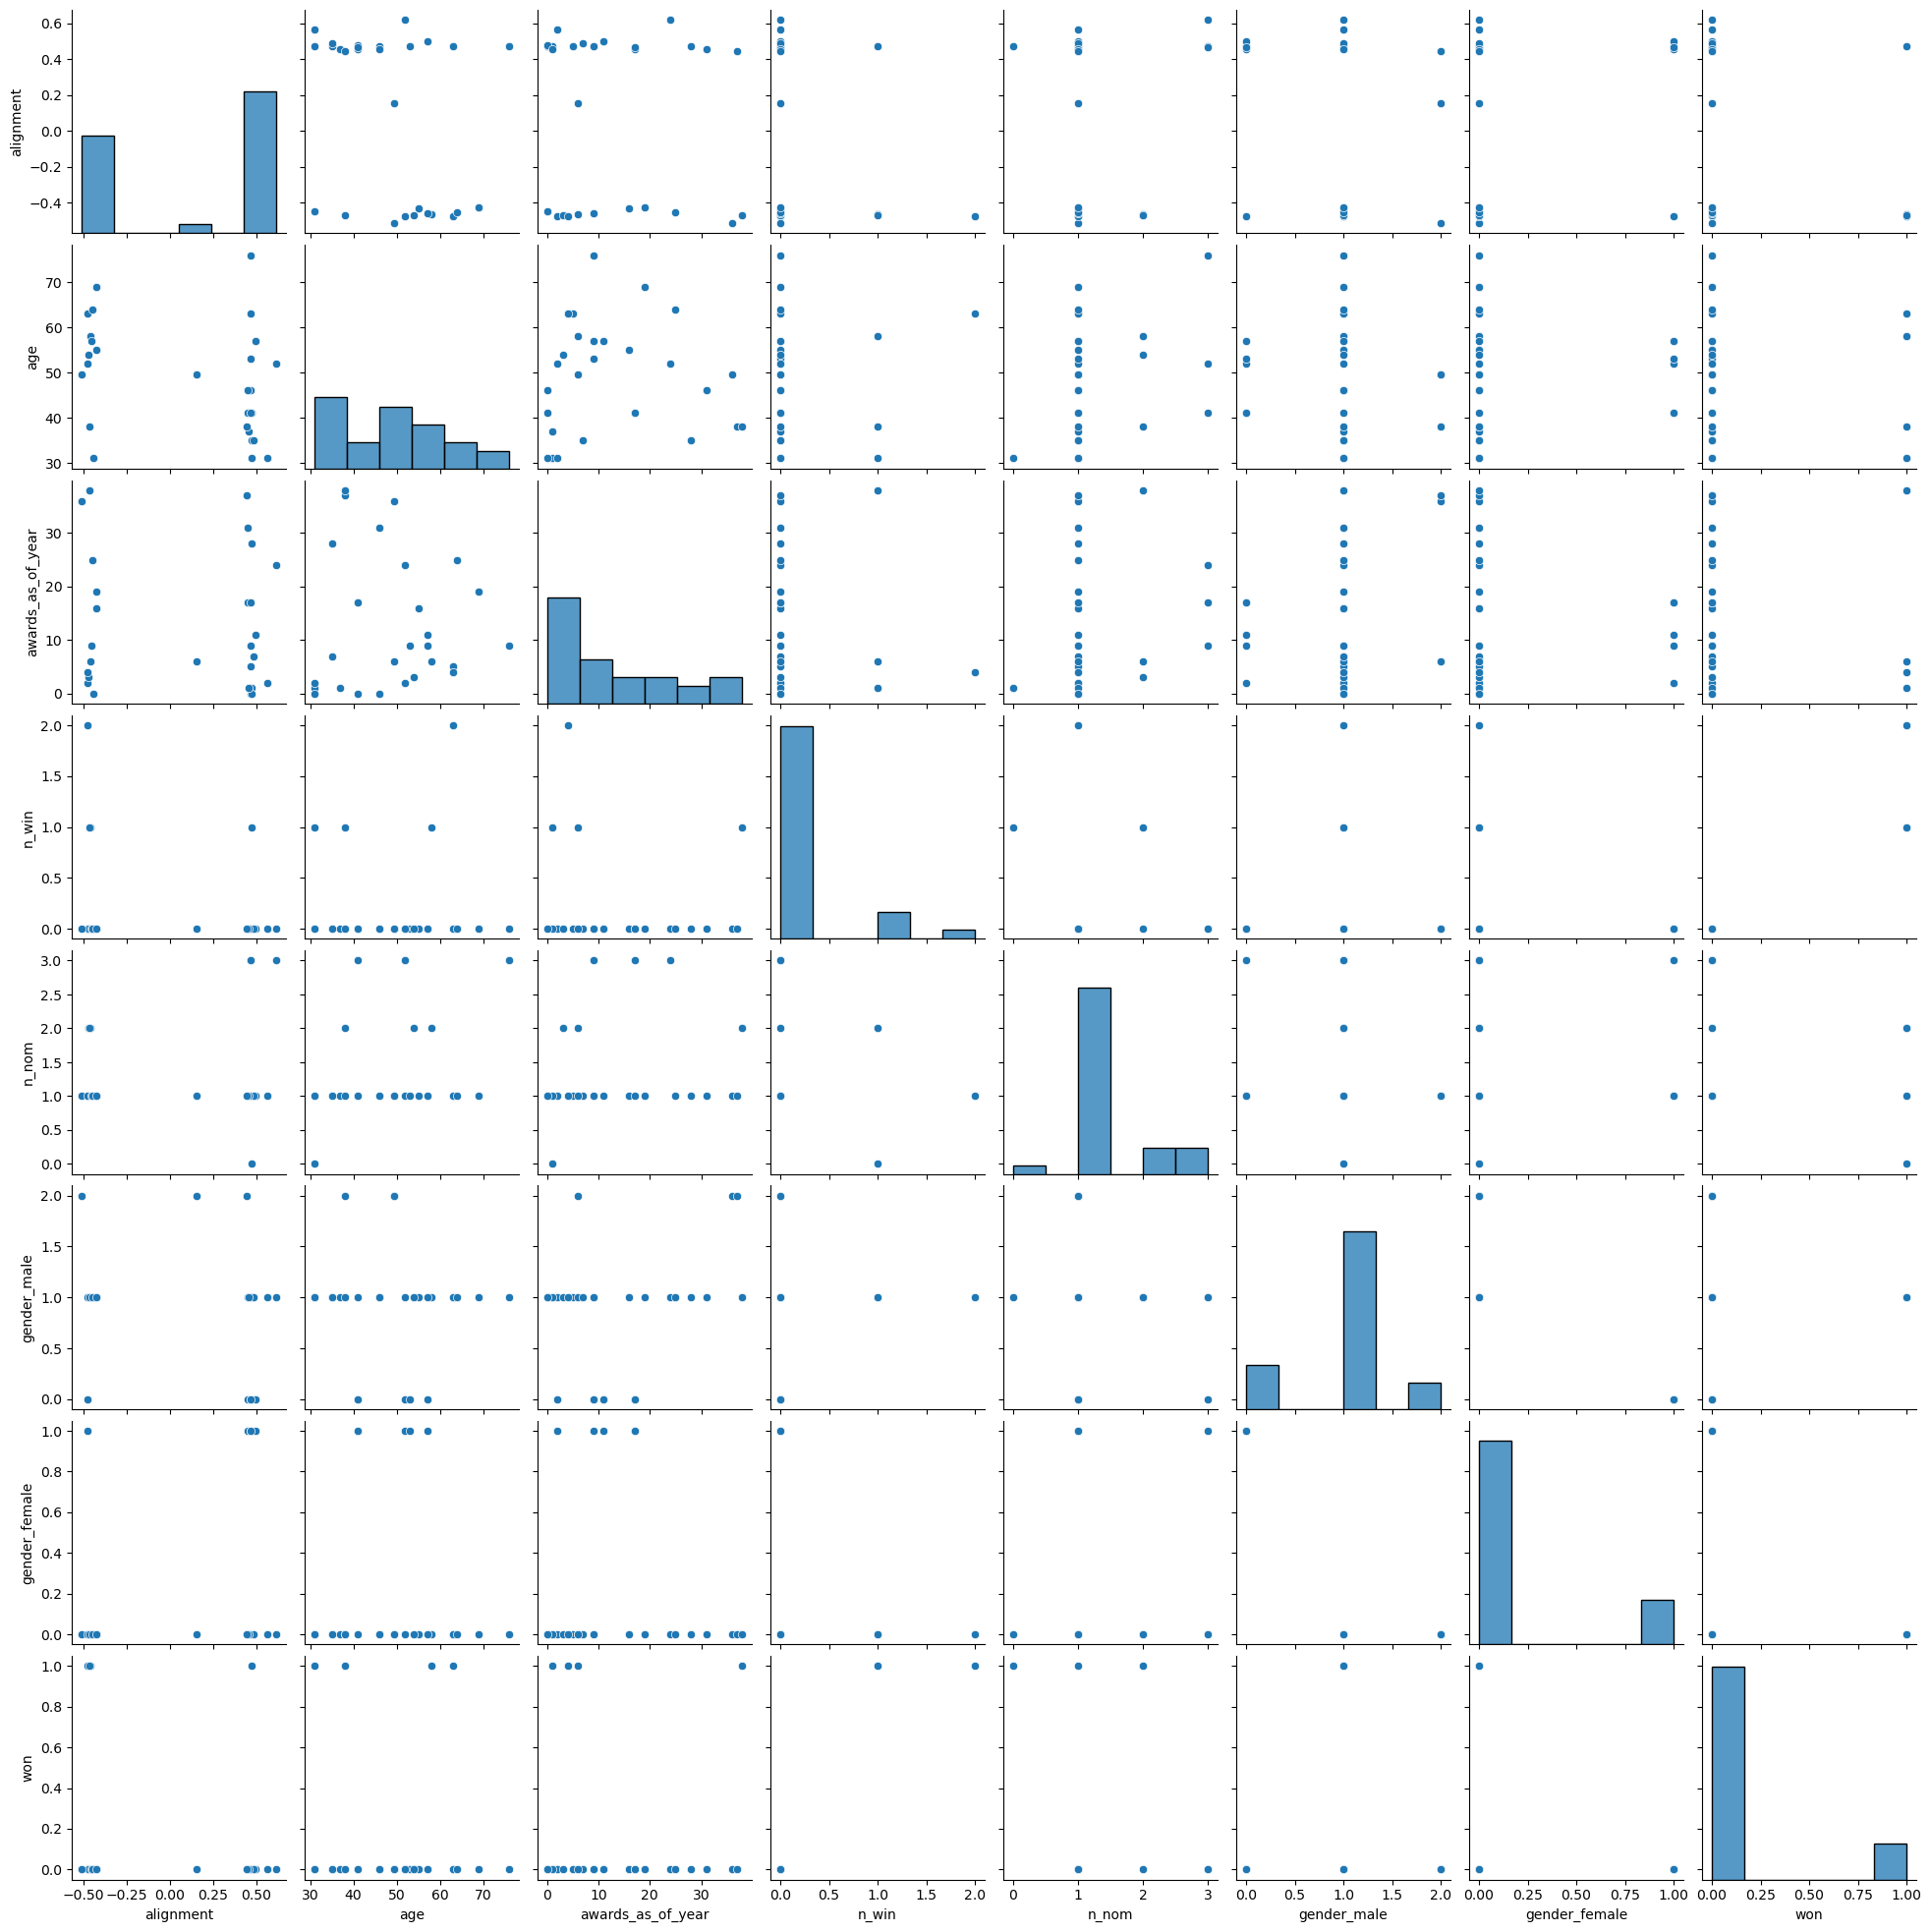

In [29]:
sns.pairplot(desc_aligned[desc_aligned.metric == "cosine"].reset_index().drop(columns=["work_qid", "embedding", "metric"]))

In [30]:
(desc_aligned[desc_aligned.n_win > 0].alignment.mean(), desc_aligned[desc_aligned.n_win == 0].alignment.mean())

(np.float64(-0.11611692734811926), np.float64(0.20539462385821947))